# Topic Modeling

In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear approximately equally in both.

Topic modeling is a technique of extracting hidden topics from a volume of text. Topic modeling is a classic solution to the problem of information retrieval using linked data and semantic web technology. Related models and techniques are, among others, latent semantic indexing, independent component analysis, probabilistic latent semantic indexing, non-negative matrix factorization, Gamma-Poisson distribution and Latent Derichlet Allocation (LDA). Source: <a href='https://en.wikipedia.org/wiki/Topic_model'>wikipedia</a>

### Import required libraries

In [1]:
# !pip install pyLDAvis # Uncomment and install this visualization library

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Data manipulation
import pandas as pd
import numpy as np
from collections import Counter
from pprint import pprint

# Data preprocessing & cleaning
import re
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

# Modeling
import gensim

# Model Evaluation
from gensim.models import CoherenceModel

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim 

In [4]:
plt.style.use('ggplot')

### Load dataset

We will use 20-Newsgroups dataset. The dataset contains around 11k newsgroups posts from 20 different topics. The dataset is found here <a href='https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json'>newsgroups</a>

In [5]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

Check firt 5 rows 

In [6]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


Check rows and columns

In [7]:
df.shape

(11314, 3)

### Preprocess Data

Remove emails

In [8]:
data = df.content.values.tolist() # Convert to list first

In [9]:
data = [re.sub('\'S*@\'S*\'s?', '', sent) for sent in data] #Remove email addresses

Remove new line characters

In [10]:
data = [re.sub('\'s+', ' ', sent) for sent in data]

Remove distracting single quotes

In [11]:
data = [re.sub("\'", "", sent) for sent in data]

Tokenize the text

In [12]:
def tokenize_to_words(text):
    for t in text:
        yield(gensim.utils.simple_preprocess(str(t), deacc=True))  # deacc=True removes punctuations

In [13]:
tokenized_data = list(tokenize_to_words(data))

Remove stopwords

In [14]:
def remove_stopwords(text):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords.words('english')] for doc in text]

In [15]:
# stop_words=stopwords.words('english')
# tokenized_data['content']=tokenized_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [16]:
tokenized_data=remove_stopwords(tokenized_data)

### Create Data Input to Model

1. Create Dictionary

In [17]:
id2word = corpora.Dictionary(tokenized_data)

2. Create Corpus (Term Document Frequency)

In [18]:
corpus = [id2word.doc2bow(text) for text in tokenized_data]

Show corpus and frequency

In [19]:
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('addition', 1), ('anyone', 2), ('body', 1), ('bricklin', 1), ('brought', 1), ('bumper', 1), ('called', 1), ('car', 5), ('college', 1), ('could', 1), ('day', 1), ('door', 1), ('doors', 1), ('early', 1), ('edu', 2), ('engine', 1), ('enlighten', 1), ('front', 1), ('funky', 1), ('history', 1), ('host', 1), ('il', 1), ('info', 1), ('know', 1), ('late', 1), ('lerxst', 2), ('lines', 1), ('looked', 1), ('looking', 1), ('made', 1), ('mail', 1), ('maryland', 1), ('model', 1), ('name', 1), ('neighborhood', 1), ('nntp', 1), ('organization', 1), ('park', 1), ('please', 1), ('posting', 1), ('production', 1), ('rac', 1), ('really', 1), ('rest', 1), ('saw', 1), ('separate', 1), ('small', 1), ('specs', 1), ('sports', 1), ('subject', 1), ('tellme', 1), ('thanks', 1), ('thing', 1), ('umd', 2), ('university', 1), ('wam', 2), ('whatever', 1), ('wondering', 1), ('years', 1)]]


### Modeling LDA Topic model

#### Latent Dirichlet allocation (LDA)

Latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model and belongs to the machine learning toolbox and in wider sense to the artificial intelligence toolbox. Source: <a href='https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation'>wikipedia</a>

In the LDA model below we specify chunksize which is the number of document to use for each training iteration/chunk. passes is the total number of training pass.

In [20]:
model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=6, random_state=100, update_every=1,
                                           chunksize=100,passes=10,alpha='auto',per_word_topics=True)

Show topics

Each keyword has a weighted importance value

In [21]:
pprint(model.print_topics())

[(0,
  '0.009*"people" + 0.009*"would" + 0.007*"one" + 0.006*"god" + 0.005*"jesus" '
  '+ 0.005*"dont" + 0.005*"us" + 0.004*"said" + 0.004*"think" + 0.004*"mr"'),
 (1,
  '0.019*"la" + 0.010*"ei" + 0.009*"bhj" + 0.009*"geb" + 0.009*"pitt" + '
  '0.009*"gordon" + 0.009*"banks" + 0.008*"pl" + 0.008*"ey" + 0.007*"tb"'),
 (2,
  '0.297*"ax" + 0.022*"max" + 0.009*"windows" + 0.006*"card" + 0.006*"drive" + '
  '0.005*"sale" + 0.004*"pl" + 0.004*"mb" + 0.004*"pc" + 0.004*"window"'),
 (3,
  '0.013*"file" + 0.009*"uiuc" + 0.008*"de" + 0.007*"edu" + 0.007*"cso" + '
  '0.006*"uk" + 0.006*"buffalo" + 0.005*"monitor" + 0.005*"vesa" + '
  '0.005*"caltech"'),
 (4,
  '0.016*"com" + 0.012*"use" + 0.008*"system" + 0.007*"information" + '
  '0.006*"available" + 0.005*"also" + 0.005*"key" + 0.005*"data" + '
  '0.005*"using" + 0.004*"used"'),
 (5,
  '0.025*"edu" + 0.013*"lines" + 0.013*"subject" + 0.013*"organization" + '
  '0.010*"com" + 0.008*"writes" + 0.008*"article" + 0.007*"university" + '
  '0.006*"po

### Model Evaluation

1. Model perplexity

In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample. <a href='https://en.wikipedia.org/wiki/Perplexity'>wikipedia</a>

In [22]:
model.log_perplexity(corpus)

-9.026972197064067

2. Topic Coherence 

Topic coherence is a metric that returns the coherene score with is a measure of the degree of semantic similarity between high scoring words in the topic

In [23]:
model_coherence = CoherenceModel(model=model, texts=tokenized_data, dictionary=id2word, coherence='c_v')

In [24]:
model_coherence.get_coherence()

0.5118737367428591

### Visualize the topics

In [25]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(model, corpus, id2word)

In [26]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.231464 -0.034650       1        1  40.844734
0      0.243013 -0.028253       2        1  25.923973
4      0.144435 -0.016272       3        1  14.055717
2     -0.271215 -0.293463       4        1  10.951487
3     -0.138375  0.220536       5        1   4.272342
1     -0.209322  0.152102       6        1   3.951750, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
5391   Default  65876.000000            ax  65876.000000  30.0000  30.0000
14     Default  21606.000000           edu  21606.000000  29.0000  29.0000
4846   Default   4943.000000           max   4943.000000  28.0000  28.0000
314    Default  12362.000000           com  12362.000000  27.0000  27.0000
401    Default   4953.000000           use   4953.000000  26.0000  26.0000
26     Default  11835.000000         lines  11835.000000  25.0000  25.0000
36     Default  11279.000000  organization  11279.000000  24.0000  24.0000
517    Default   5215.000000        people   5215.000000  23.0000  23.0000
3184   Default   1671.000000            la   1671.000000  22.0000  22.0000
411    Default   7876.000000        writes   7876.000000  21.0000  21.0000
49     Default  12335.000000       subject  12335.000000  20.0000  20.0000
54     Default   5752.000000    university   5752.000000  19.0000  19.0000
250    Default   1893.000000       windows   1893.000000  18.0000  18.0000
3107   Default   2189.000000   information   2189.000000  17.0000  17.0000
579    Default   2893.000000           god   2893.000000  16.0000  16.0000
240    Default   2717.000000        system   2717.000000  15.0000  15.0000
1311   Default   2626.000000         jesus   2626.000000  14.0000  14.0000
2006   Default   1085.000000          file   1085.000000  13.0000  13.0000
1995   Default   3901.000000            ca   3901.000000  12.0000  12.0000
2241   Default   1491.000000            pl   1491.000000  11.0000  11.0000
35     Default   4657.000000          nntp   4657.000000  10.0000  10.0000
2867   Default   2424.000000            mr   2424.000000   9.0000   9.0000
186    Default   1656.000000     available   1656.000000   8.0000   8.0000
20     Default   4849.000000          host   4849.000000   7.0000   7.0000
862    Default   1103.000000          pitt   1103.000000   6.0000   6.0000
1996   Default   1542.000000          card   1542.000000   5.0000   5.0000
325    Default   1811.000000         drive   1811.000000   4.0000   4.0000
39     Default   5451.000000       posting   5451.000000   3.0000   3.0000
4551   Default   1562.000000            uk   1562.000000   2.0000   2.0000
181    Default   9722.000000         would   9722.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
8878    Topic6    289.150696            mf    290.053101   3.2279  -5.6238
11657   Topic6    283.104706            sk    284.040009   3.2277  -5.6449
2664    Topic6    264.712860         bikes    265.599731   3.2277  -5.7121
20200   Topic6    259.837494            jb    260.718781   3.2276  -5.7307
7186    Topic6    254.619415            mc    255.505524   3.2275  -5.7510
8006    Topic6    260.735260            mt    261.677948   3.2274  -5.7273
3123    Topic6    224.539078    skepticism    225.423615   3.2271  -5.8767
21554   Topic6    269.426361            yf    270.495514   3.2271  -5.6945
19912   Topic6    224.755707            fq    225.651520   3.2270  -5.8757
3827    Topic6    202.212723            mk    203.092926   3.2267  -5.9814
20394   Topic6    202.663406            lg    203.550400   3.2266  -5.9792
21183   Topic6    198.129684            tl    199.006134   3.2266  -6.0018
9383    Topic6    198.956161            kg    199.848618   3.2265  -5.9977
3091    Topic6    192.048264      chastity    192.933365   3.2264  -6.0330


##### Interpreting the Visual

Each bubble on the left graph represents a topic. The larger the bubble, the more prevalent is that topic. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

### 1. Dominant topic in each sentence

To get the dominant topic in each sentence we compute the percentage contribution of each topic.

In [27]:
def topics_in_sentences(model=None, corpus=corpus, texts=data):
    # Initialize an empty dataframe
    sentence_topics_df = pd.DataFrame()

    # Loop through each document and each sentence to get the key topics
    for i, row_list in enumerate(model[corpus]):
        row = row_list[0] if model.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # For each document extract the topic percentage contribution and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sentence_topics_df = sentence_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sentence_topics_df.columns = ['Dominant_Topic', 'Pct_Contribution', 'Topic_Keywords']

    # Append original text to the end of the output
    contents = pd.Series(texts)
    sentence_topics_df = pd.concat([sentence_topics_df, contents], axis=1)
    return(sentence_topics_df)


sentence_topics_keywords_df = topics_in_sentences(model=model, corpus=corpus, texts=tokenized_data)

# Format
dominant_topic_df = sentence_topics_keywords_df.reset_index()
dominant_topic_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Pct_Contribution', 'Keywords', 'Text']

In [29]:
dominant_topic_df.head()

,Document_No,Dominant_Topic,Topic_Pct_Contribution,Keywords,Text
0,0,5.0,0.9426,"edu, lines, subject, organization, com, writes...","[lerxst, wam, umd, edu, thing, subject, car, n..."
1,1,5.0,0.5430,"edu, lines, subject, organization, com, writes...","[guykuo, carson, washington, edu, guy, kuo, su..."
2,2,5.0,0.9388,"edu, lines, subject, organization, com, writes...","[irwin, cmptrc, lonestar, org, irwin, arnstein..."
3,3,4.0,0.3599,"com, use, system, information, available, also...","[tchen, magnus, acs, ohio, state, edu, tsung, ..."
4,4,5.0,0.4304,"edu, lines, subject, organization, com, writes...","[dabl, nlm, nih, gov, lindbergh, subject, diam..."


### 2. The most representative sentence for each topic

In [30]:
# pd.options.display.max_colwidth = 100

sorted_sentence_topics_df = pd.DataFrame()
grouped_sentence_topics_df = sentence_topics_keywords_df.groupby('Dominant_Topic')

for i, grp in grouped_sentence_topics_df:
    sorted_sentence_topics_df = pd.concat([sorted_sentence_topics_df, 
                                             grp.sort_values(['Pct_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sorted_sentence_topics_df.reset_index(drop=True, inplace=True)

# Format columns
sorted_sentence_topics_df.columns = ['Topic_Num', "Topic_Pct_Contrib", "Keywords", "Representative Text"]

In [31]:
sorted_sentence_topics_df.head(10)

,Topic_Num,Topic_Pct_Contrib,Keywords,Representative Text
0,0.0,0.9011,"people, would, one, god, jesus, dont, us, said...","[sera, zuma, uucp, serdar, argic, subject, ent..."
1,1.0,0.9884,"la, ei, bhj, geb, pitt, gordon, banks, pl, ey, tb","[subject, roman, bmp, pwiseman, salmon, usd, e..."
2,2.0,0.9765,"ax, max, windows, card, drive, sale, pl, mb, p...","[subject, roman, bmp, pwiseman, salmon, usd, e..."
3,3.0,0.6113,"file, uiuc, de, edu, cso, uk, buffalo, monitor...","[zaphod, mps, ohio, state, edu, wupost, uunet,..."
4,4.0,0.8383,"com, use, system, information, available, also...","[bontchev, fbihh, informatik, uni, hamburg, de..."
5,5.0,0.9842,"edu, lines, subject, organization, com, writes...","[ff, jupiter, sun, csd, unb, ca, cook, charlie..."


### 3. Topic distribution across documents

In [32]:
# Number of Documents for Each Topic
topic_counts = sentence_topics_keywords_df['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sentence_topics_keywords_df[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
dominant_topics_df = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
dominant_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Pct_Documents']

In [33]:
dominant_topics_df.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Pct_Documents
0,5.0,"edu, lines, subject, organization, com, writes...",2100.0,0.1856
1,5.0,"edu, lines, subject, organization, com, writes...",18.0,0.0016
2,5.0,"edu, lines, subject, organization, com, writes...",354.0,0.0313
3,4.0,"com, use, system, information, available, also...",140.0,0.0124
4,5.0,"edu, lines, subject, organization, com, writes...",801.0,0.0708


### 4. Word Clouds of Top N Keywords in Each Topic

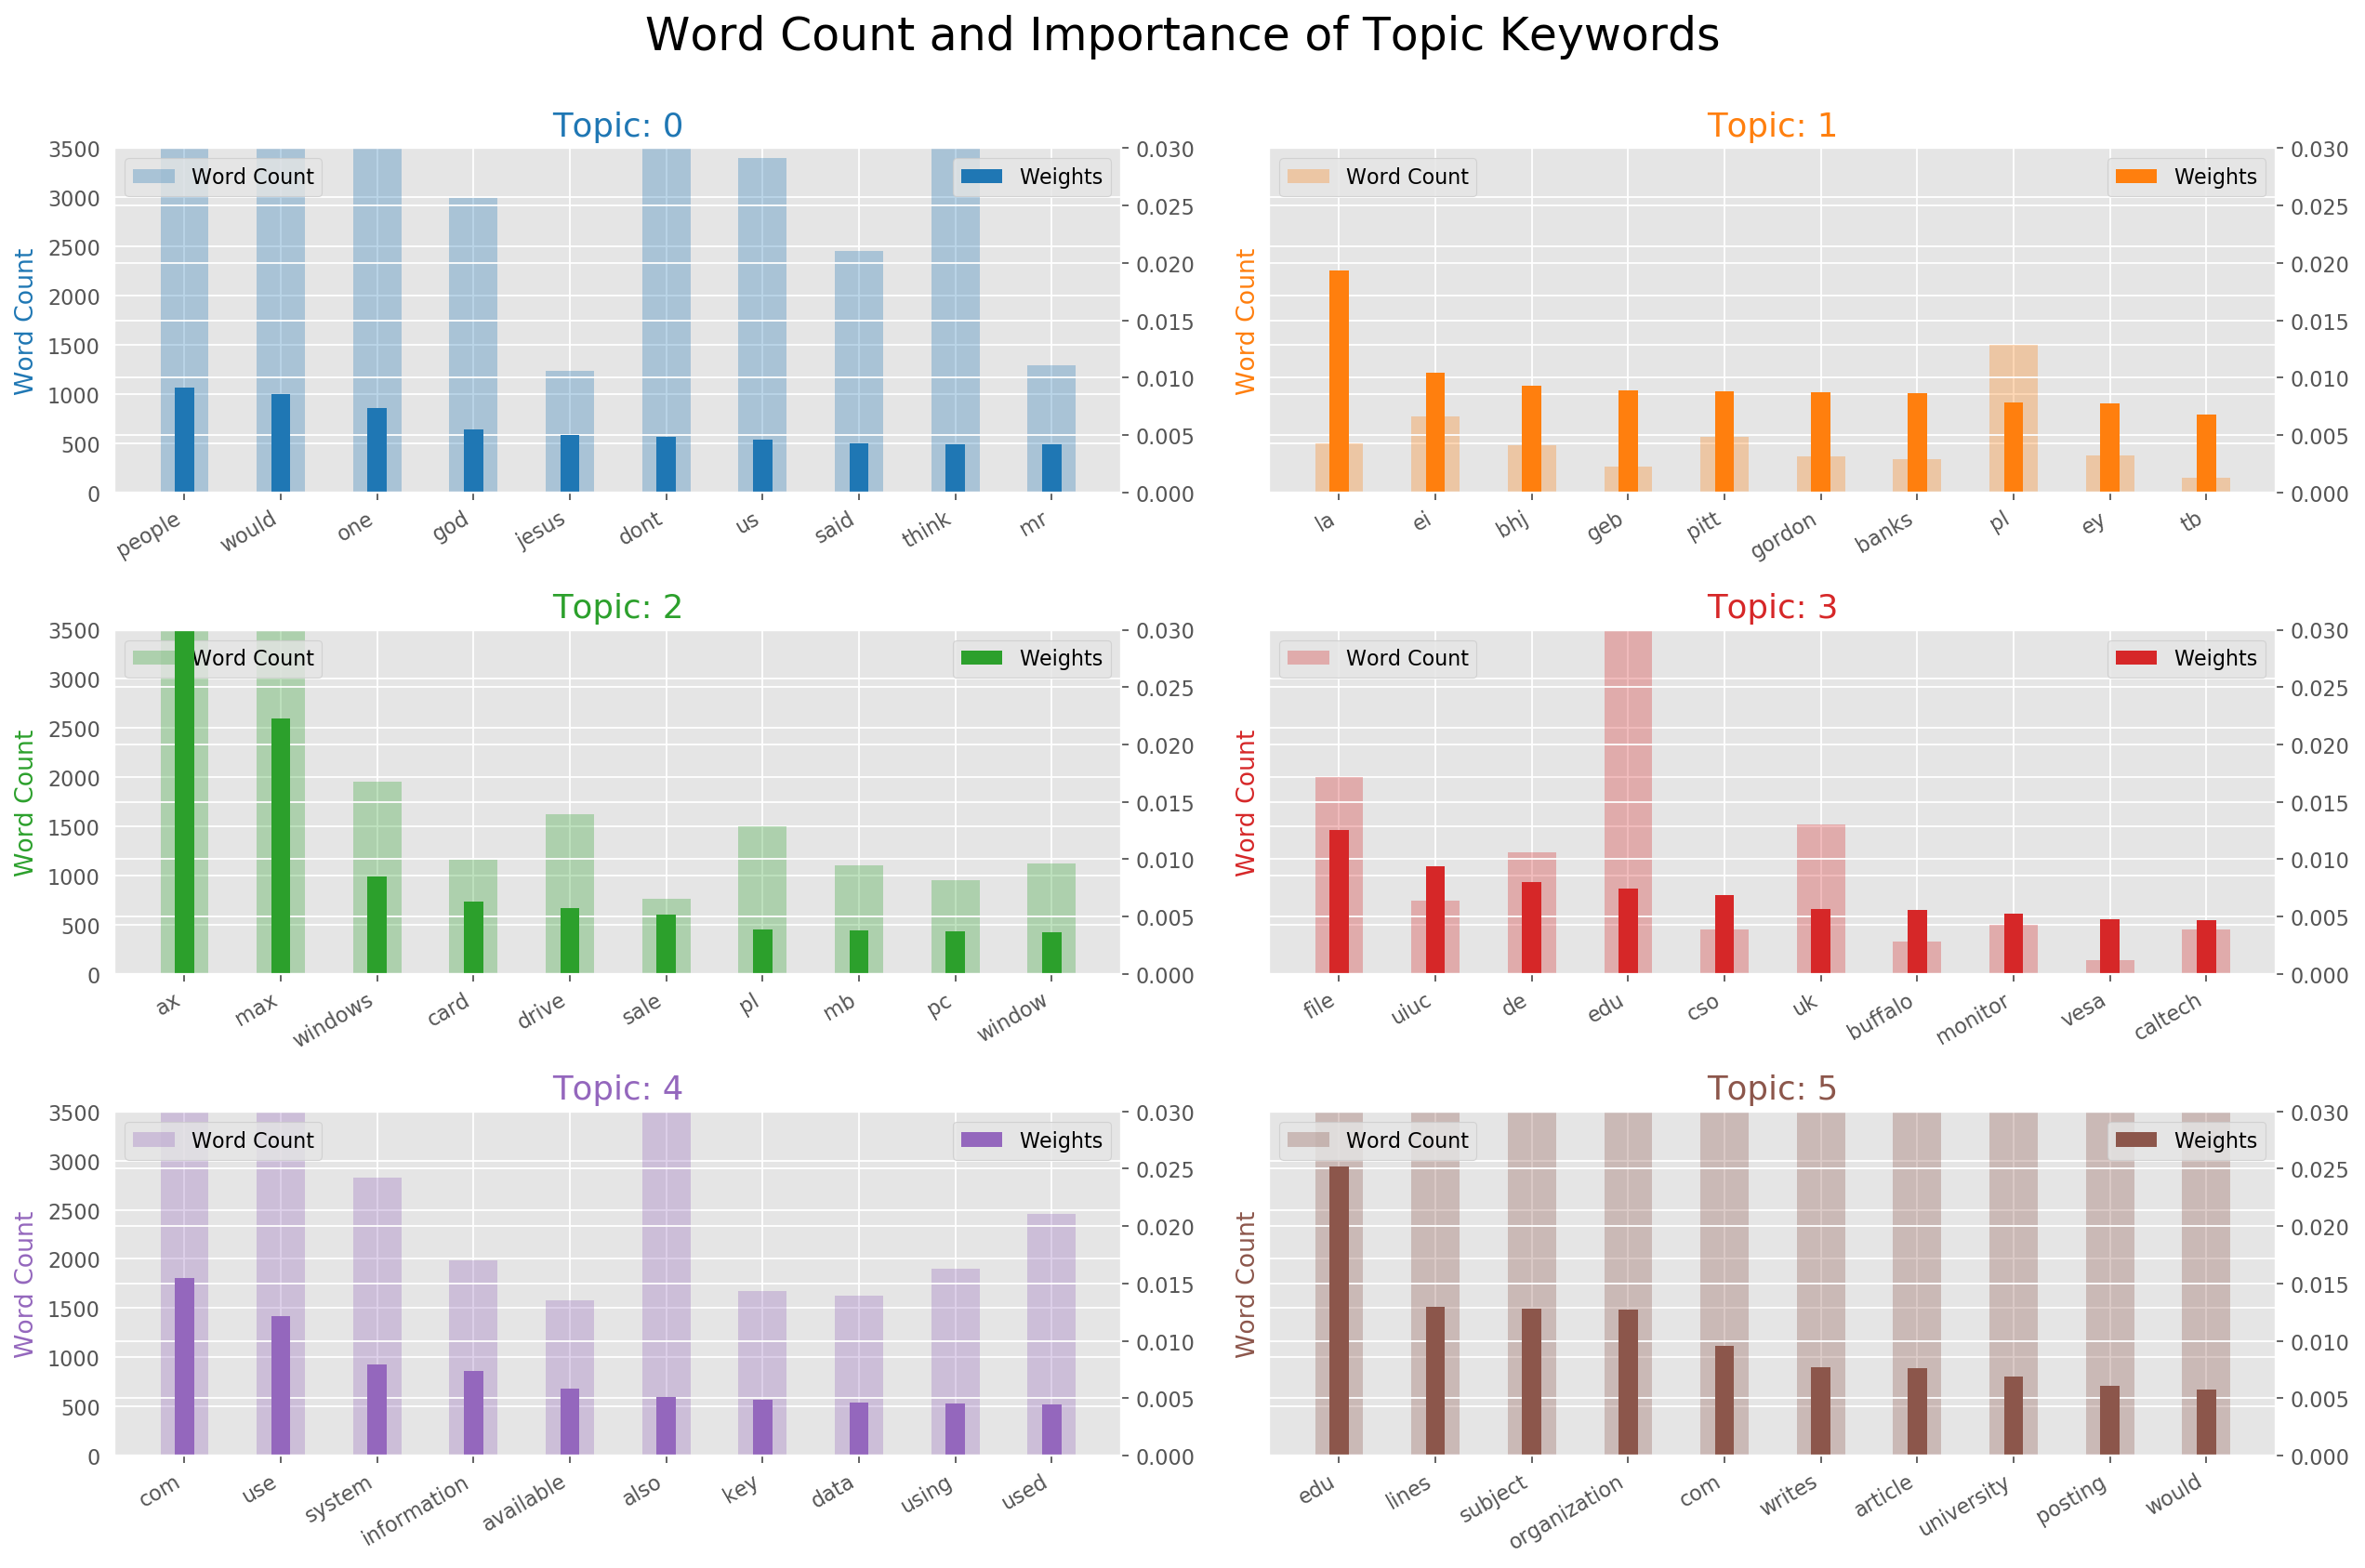

In [37]:
topics = model.show_topics(formatted=False)
data_flat = [w for w_list in tokenized_data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

word_cloud_df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=word_cloud_df.loc[word_cloud_df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=word_cloud_df.loc[word_cloud_df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(word_cloud_df.loc[word_cloud_df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### 5. Most discussed topics in the documents

In [38]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

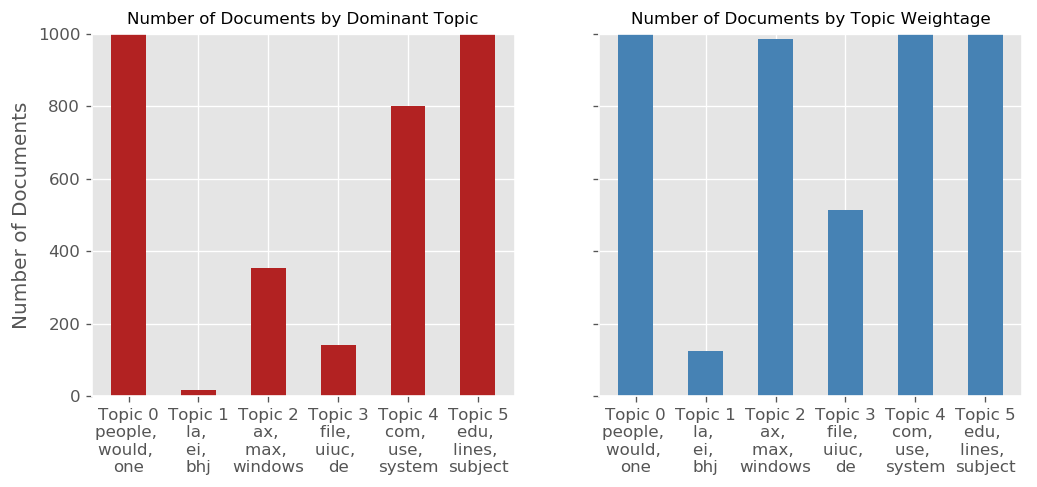

In [39]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.show()

### Model Tuning

Getting most optimal number of topics

In [40]:
limit=50; 
start=1; 
step=6;

In [41]:
def compute_optimal_topics(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [42]:
model_list, coherence_values = compute_optimal_topics(dictionary=id2word, corpus=corpus, texts=tokenized_data, start=start, limit=limit, step=step)

Vsualize

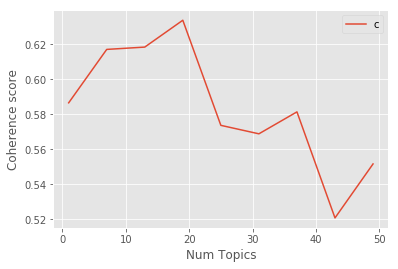

In [43]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Show topics and coherence values

In [44]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 1  is having Coherence Value of 0.5866
Num Topics = 7  is having Coherence Value of 0.6171
Num Topics = 13  is having Coherence Value of 0.6185
Num Topics = 19  is having Coherence Value of 0.6338
Num Topics = 25  is having Coherence Value of 0.5737
Num Topics = 31  is having Coherence Value of 0.5689
Num Topics = 37  is having Coherence Value of 0.5814
Num Topics = 43  is having Coherence Value of 0.5208
Num Topics = 49  is having Coherence Value of 0.5517


### Other Topic Modeling Algorithms Implemented in gensim

#### 1. LDA Mallet Model

MAchine Learning for LanguagE Toolkit (MALLET) is an open source toolkit developed by Andrew McCullum. It is a Java based package which is used for NLP tasks such as document classification, clustering, topic modeling e.t.c. Mallet provides Topic Modeling capabilities which contains an efficient, sampling-based implementations of LDA as well as Hierarchical LDA.

To use MALLET we must download it from here<a href='http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip'>mallet</a> and unzip it in a local directory.

Locate the Mallet file

In [45]:
# import os
# os.environ.update({'MALLET_HOME':r'C:/mallet/mallet-2.0.8/'})

In [46]:
# mallet_path = 'C:/mallet/mallet-2.0.8/bin/mallet' # update this path to where you have unzipped your mallet file
# mallet_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [49]:
# # Compute Coherence Score
# coherence_mallet_model = CoherenceModel(model=mallet_model, texts=tokenized_data, dictionary=id2word, coherence='c_v')
# coherence_mallet_model.get_coherence()

#### 2. Hierarchical Dirichlet Process (HPD) Model

hierarchical Dirichlet process (HDP) is a nonparametric Bayesian approach to clustering grouped data.[1][2] It uses a Dirichlet process for each group of data, with the Dirichlet processes for all groups sharing a base distribution which is itself drawn from a Dirichlet process. This method allows groups to share statistical strength via sharing of clusters across groups. The base distribution being drawn from a Dirichlet process is important, because draws from a Dirichlet process are atomic probability measures, and the atoms will appear in all group-level Dirichlet processes <a href='https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process'>wikipedia</a>.

HDP is an extension of LDA model and is designed to handle where the number of mixture components (the number of "topics" in document-modeling terms) is not known.In HPD maximum number of topics can be unbounded and learned from the data rather than specified in advance.

Modeling with HDP

In [50]:
hdp_model = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=id2word)

In [51]:
# Compute Coherence Score
coherence_hdp_model = CoherenceModel(model=hdp_model, texts=tokenized_data, dictionary=id2word, coherence='c_v')
coherence_hdp_model.get_coherence()

0.5162111886591665

#### 3. Latent Semantic Indexing (LSI)

Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts. source:<a href='https://en.wikipedia.org/wiki/Latent_semantic_analysis#LSI_timeline'>wikipedia</a>

Modeling with LSI

In [52]:
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=6,chunksize=100)

In [53]:
# Compute Coherence Score
coherence_lsi_model = CoherenceModel(model=lsi_model, texts=tokenized_data, dictionary=id2word, coherence='c_v')
coherence_lsi_model.get_coherence()

0.6928539586908452

### Conclusion

How to improve the model:<hr>
1. Improve on text processing.
2. The variety of topics the text talks about.
3. Topic modeling algorithm to use.
4. The number of topics to be retrieved from the algorithm.
5. The Model hyperparameter tuning.